## 17807671 Shivam Pandey
### Assignment3 CE784A
> For complete source code pl. refer to following repositories
> https://github.com/ShivamPR21/ModuleZooTorch
> https://github.com/ShivamPR21/Driver-Gaze-Zone-Classification
> Code credit @ShivamPR21

### Import relevent modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
import torch.nn as nn
import torchsummary
import torch
import torch.optim as optim

from dgzc.dataset import DGZCClassifierDataset
from dgzc.classifier import ClassificationBackbone2

### Define training dataset

In [2]:
data_path = "/home/shivam/2021-22-2/ML4CE/Assignments/Assignment3/Driver-Gaze-Zone-Classification/data/gaze_dataset"
# dataset_auto_enc = DGZCAutoEncoderDataset(data_path, size=(200, 200))
dataset_classifier = DGZCClassifierDataset(data_path, size=(200, 200))
# dataset_inference = DGZCInferenceDataset(data_path, size=(200, 200))

### Create the dataloader with batch size `10`

In [3]:
dataloader = DataLoader(dataset_classifier, batch_size = 10, shuffle = True, num_workers=5)

### Set the device to GPU if available

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
data_len = len(dataloader)
log_n = int(data_len//3)

### Create model instance

In [6]:
model = ClassificationBackbone2(l=1.)
model.to(device)

ClassificationBackbone2(
  (encoder): Encoder(
    (conv1): Conv2DNormActivation(
      (0): Conv2d(3, 5, kernel_size=(5, 5), stride=(2, 2))
      (1): SELU()
    )
    (conv2): Conv2DNormActivation(
      (0): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1), bias=False)
      (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
    )
    (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2DNormActivation(
      (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
      (1): SELU()
    )
    (conv4): Conv2DNormActivation(
      (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
      (1): SELU()
    )
    (conv5): Conv2DNormActivation(
      (0): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
    )
    (conv6): Conv2DNormActivation(
      (0): Conv2d(30, 4

### Load pretrained weight dicts

In [7]:
load_prev_auto_enc_state = False
load_prev_model_state = True
if load_prev_auto_enc_state:
    model.encoder.load_state_dict(torch.load('./encoder_state'))
elif load_prev_model_state:
    model.load_state_dict(torch.load('./simple_backbone2_model'))

### View model summary

In [8]:
torchsummary.summary(model, (3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 98, 98]             380
              SELU-2            [-1, 5, 98, 98]               0
            Conv2d-3           [-1, 10, 94, 94]           1,250
       BatchNorm2d-4           [-1, 10, 94, 94]              20
              SELU-5           [-1, 10, 94, 94]               0
         MaxPool2d-6           [-1, 10, 47, 47]               0
            Conv2d-7           [-1, 20, 45, 45]           1,820
              SELU-8           [-1, 20, 45, 45]               0
            Conv2d-9           [-1, 20, 43, 43]           3,620
             SELU-10           [-1, 20, 43, 43]               0
           Conv2d-11           [-1, 30, 41, 41]           5,400
      BatchNorm2d-12           [-1, 30, 41, 41]              60
             SELU-13           [-1, 30, 41, 41]               0
           Conv2d-14           [-1, 40,

### Define loss function, and optimizer instances

In [9]:
criterion =  nn.CrossEntropyLoss() # Classification Loss function
params_list = model.parameters() # model parameters
optimizer = optim.AdamW(params_list, lr = 0.0007, weight_decay=0.0001)

### Define function to compute loss, and accuracy

In [10]:
def compute_loss(dl, model, crt):
    total_loss = 0.
    cnt = 0
    total = 0
    correct = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data, target in dl:
            data = data.to(device)
            target = target.to(device)
            
            # calculate outputs by running images through the network
            cls = model(data)

            loss = crt(cls, target)
            
            total_loss += loss.item()
            
            predictions = cls.max(dim=1)[1]
            total += predictions.size(0)
            correct += (predictions == target).sum().item()
            cnt += 1
            
    return [total_loss/cnt, correct/total]

### Set model as trainable

In [11]:
rll = []
total_loss = []

In [12]:
model.train()

ClassificationBackbone2(
  (encoder): Encoder(
    (conv1): Conv2DNormActivation(
      (0): Conv2d(3, 5, kernel_size=(5, 5), stride=(2, 2))
      (1): SELU()
    )
    (conv2): Conv2DNormActivation(
      (0): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1), bias=False)
      (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
    )
    (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2DNormActivation(
      (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
      (1): SELU()
    )
    (conv4): Conv2DNormActivation(
      (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
      (1): SELU()
    )
    (conv5): Conv2DNormActivation(
      (0): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
    )
    (conv6): Conv2DNormActivation(
      (0): Conv2d(30, 4

### Run the training loop for 50 epochs

In [13]:
for epoch in range(50):
    running_loss = 0.
    total = 0.
    correct = 0.
    for i, (data, target) in enumerate(dataloader):
        data = data.to(device) # Move data to target device
        target = target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        cls = model(data)
        
        loss = criterion(cls, target)
        
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
        predictions = cls.max(dim=1)[1]
        total += predictions.size(0)
        correct += (predictions == target).sum().item()
        
        if i%log_n == log_n-1:
            rll += [epoch, i, running_loss]
            print(f'Epoch : {epoch}, Iteration : {i},Running loss : {running_loss/log_n}, Train Accuracy : {correct/total}')
            running_loss, total, correct = 0, 0, 0
    if epoch%10 == 0:
        total_loss += [compute_loss(dataloader, model, criterion)]
        print(f'Total loss : {total_loss[-1]}')

Epoch : 0, Iteration : 82,Running loss : 1.0676548746695, Train Accuracy : 0.8409638554216867
Epoch : 0, Iteration : 165,Running loss : 1.083013941006488, Train Accuracy : 0.8253012048192772
Epoch : 0, Iteration : 248,Running loss : 1.0893113081713757, Train Accuracy : 0.8240963855421687
Total loss : [1.071226634979248, 0.8404]
Epoch : 1, Iteration : 82,Running loss : 1.0493211128625526, Train Accuracy : 0.8566265060240964
Epoch : 1, Iteration : 165,Running loss : 1.088340223553669, Train Accuracy : 0.8180722891566266
Epoch : 1, Iteration : 248,Running loss : 1.0670434940292175, Train Accuracy : 0.8409638554216867
Epoch : 2, Iteration : 82,Running loss : 1.0455826456288257, Train Accuracy : 0.8674698795180723
Epoch : 2, Iteration : 165,Running loss : 1.0741092584219323, Train Accuracy : 0.8301204819277108
Epoch : 2, Iteration : 248,Running loss : 1.0780946332288075, Train Accuracy : 0.8337349397590361
Epoch : 3, Iteration : 82,Running loss : 1.0438413361468948, Train Accuracy : 0.86385

KeyboardInterrupt: 

### Plot the loss vs iterations

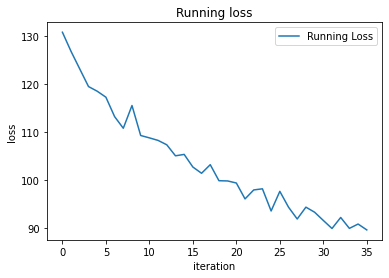

In [19]:
plt.plot(np.array(rll).reshape((-1, 3))[:, 2], label='Running Loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Running loss')
plt.legend()
plt.show()

### Plot the Loss, and Accuray vs epochs

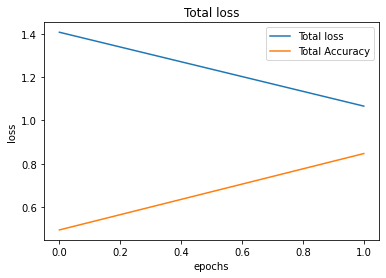

In [20]:
plt.plot(total_loss, label=['Total loss', 'Total Accuracy'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Total loss')
plt.legend()
plt.show()

### Save the model

In [21]:
torch.save(model.encoder.state_dict(), './encoder_state_simple_backbone2')
torch.save(model.state_dict(), './simple_backbone2_model')

> For inference pl. look at the `Inference Attention Classifier` notebook

> The notebook doesn't contain actual graphs, as the training process was complex, and storing graphs were not possible, one need to run the training loop to see the graphs.

> There are more .ipynb related to different models in the same directory.
> All of them trained upto training accuracy upto `84%`